In [2]:
import matplotlib.pyplot as plt
import glob
import os
import numpy as np
from sklearn.model_selection import train_test_split
from io import BytesIO
import tensorflow as tf
import numpy as np
from tensorflow.python.lib.io import file_io
import yaml
from yaml.loader import SafeLoader
from google.cloud import storage
import io

## TFrecords for CNN

In [6]:
def load_data(source, class_name, label, test_size=0.2, val_size=0.3, max_items_per_class= 100000):
    
    if source == 'quickdraw':
        root = 'gs://quickdraw_dataset/full/numpy_bitmap/'
        f = BytesIO(file_io.read_file_to_string(root + f'{class_name}' + '.npy', binary_mode=True))
        data = np.load(f)
    
    if source == 'local':
        root = './npy/'
        filename = root + f'{class_name}' + '.npy'
        data = np.load(filename)
    
    
    X = data[0:max_items_per_class, :]
    y = np.full(X.shape[0], label)

    #shuffle (to be sure)
    permutation = np.random.permutation(y.shape[0])
    X = X[permutation, :]
    
    #separate into training and testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=True)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size, shuffle=True)
    
    del(data)
    
    return X_train.astype(int), X_test.astype(int), X_val.astype(int), y_train.astype(int), y_test.astype(int), y_val.astype(int)

In [3]:
def load_shard_on_line(shard, test_size=0.2, max_items_per_class= 5000):
    
    path_yaml= "./categories.yaml"
    with open(path_yaml) as f:
        class_names = yaml.load(f, Loader=SafeLoader)
    
    root = 'gs://quickdraw_dataset/full/numpy_bitmap/'
    all_files=[]
    for class_name in class_names:
        all_files.append(root + f'{class_name}' + '.npy')

    #initialize variables 
    X = np.empty([0, 784])
    y = np.empty([0])
    class_names = []

    #load a subset of the data to memory 
    for idx, file in enumerate(sorted(all_files)):
        print(file)
        f = io.BytesIO(file_io.read_file_to_string(file, binary_mode=True))
        data = np.load(f)
        data = data[shard*max_items_per_class: (shard+1)*max_items_per_class, :]
        labels = np.full(data.shape[0], idx)

        X = np.concatenate((X, data), axis=0)
        y = np.append(y, labels)

        class_name, ext = os.path.splitext(os.path.basename(file))
        class_names.append(class_name.replace("full_numpy_bitmap_", "").replace(".npy", ""))

    data = None
    labels = None

    #shuffle (to be sure)
    permutation = np.random.permutation(y.shape[0])
    X = X[permutation, :]
    y = y[permutation]
    
    #separate into training and testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=True)

    return X_train.astype(int), X_test.astype(int), y_train.astype(int), y_test.astype(int), class_names

In [13]:
def load_shard(root, shard, test_size=0.2, max_items_per_class= 5000):
    
    all_files = glob.glob(os.path.join(root, '*.npy'))

    #initialize variables 
    X = np.empty([0, 784])
    y = np.empty([0])
    class_names = []

    #load a subset of the data to memory 
    for idx, file in enumerate(sorted(all_files)):
        print(file)
        data = np.load(file)
        data = data[shard*max_items_per_class: (shard+1)*max_items_per_class, :]
        labels = np.full(data.shape[0], idx)

        X = np.concatenate((X, data), axis=0)
        y = np.append(y, labels)

        class_name, ext = os.path.splitext(os.path.basename(file))
        class_names.append(class_name.replace("full_numpy_bitmap_", "").replace(".npy", ""))

    data = None
    labels = None

    #shuffle (to be sure)
    permutation = np.random.permutation(y.shape[0])
    X = X[permutation, :]
    y = y[permutation]
    
    #separate into training and testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=True)

    return X_train.astype(int), X_test.astype(int), y_train.astype(int), y_test.astype(int), class_names

In [ ]:
for shard in range(10):
    print(shard)
    X_train, X_test, y_train, y_test, class_names = load_shard_on_line(shard, test_size=0.2, max_items_per_class=10000)
    X_train = X_train.reshape(-1,28,28,1)
    X_test = X_test.reshape(-1,28,28,1)  
    y_train = y_train.reshape(-1,1)
    y_test = y_test.reshape(-1,1)
    write_images_to_tfr_short(X_train, y_train, filename=f"./tfrecords/shard_{shard}_train")
    write_images_to_tfr_short(X_test, y_test, filename=f"./tfrecords/shard_{shard}_test")

0
gs://quickdraw_dataset/full/numpy_bitmap/angel.npy
gs://quickdraw_dataset/full/numpy_bitmap/ant.npy
gs://quickdraw_dataset/full/numpy_bitmap/axe.npy
gs://quickdraw_dataset/full/numpy_bitmap/basketball.npy
gs://quickdraw_dataset/full/numpy_bitmap/bathtub.npy


In [15]:
for shard in range(10):
    print(shard)
    X_train, X_test, y_train, y_test, class_names = load_shard('./npy/', shard, test_size=0.2, max_items_per_class=10000)
    X_train = X_train.reshape(-1,28,28,1)
    X_test = X_test.reshape(-1,28,28,1)  
    y_train = y_train.reshape(-1,1)
    y_test = y_test.reshape(-1,1)
    write_images_to_tfr_short(X_train, y_train, filename=f"./tfrecords/shard_{shard}_train")
    write_images_to_tfr_short(X_test, y_test, filename=f"./tfrecords/shard_{shard}_test")

0
./npy/full_numpy_bitmap_angel.npy
./npy/full_numpy_bitmap_ant.npy
./npy/full_numpy_bitmap_axe.npy
./npy/full_numpy_bitmap_basketball.npy
./npy/full_numpy_bitmap_bathtub.npy
./npy/full_numpy_bitmap_bear.npy
./npy/full_numpy_bitmap_bed.npy
./npy/full_numpy_bitmap_brain.npy
./npy/full_numpy_bitmap_bridge.npy
./npy/full_numpy_bitmap_cactus.npy
./npy/full_numpy_bitmap_calculator.npy
./npy/full_numpy_bitmap_camel.npy
./npy/full_numpy_bitmap_camera.npy
./npy/full_numpy_bitmap_car.npy
./npy/full_numpy_bitmap_carrot.npy
./npy/full_numpy_bitmap_castle.npy
./npy/full_numpy_bitmap_cat.npy
./npy/full_numpy_bitmap_church.npy
./npy/full_numpy_bitmap_circle.npy
./npy/full_numpy_bitmap_cloud.npy
./npy/full_numpy_bitmap_coffee cup.npy
./npy/full_numpy_bitmap_couch.npy
./npy/full_numpy_bitmap_cow.npy
./npy/full_numpy_bitmap_crayon.npy
./npy/full_numpy_bitmap_crocodile.npy
./npy/full_numpy_bitmap_crown.npy
./npy/full_numpy_bitmap_diamond.npy
./npy/full_numpy_bitmap_dog.npy
./npy/full_numpy_bitmap_dolphi

./npy/full_numpy_bitmap_elephant.npy
./npy/full_numpy_bitmap_eye.npy
./npy/full_numpy_bitmap_fish.npy
./npy/full_numpy_bitmap_flamingo.npy
./npy/full_numpy_bitmap_flower.npy
./npy/full_numpy_bitmap_fork.npy
./npy/full_numpy_bitmap_frog.npy
./npy/full_numpy_bitmap_giraffe.npy
./npy/full_numpy_bitmap_guitar.npy
./npy/full_numpy_bitmap_hamburger.npy
./npy/full_numpy_bitmap_hammer.npy
./npy/full_numpy_bitmap_hand.npy
./npy/full_numpy_bitmap_harp.npy
./npy/full_numpy_bitmap_hat.npy
./npy/full_numpy_bitmap_hedgehog.npy
./npy/full_numpy_bitmap_helicopter.npy
./npy/full_numpy_bitmap_horse.npy
./npy/full_numpy_bitmap_leaf.npy
./npy/full_numpy_bitmap_line.npy
./npy/full_numpy_bitmap_lion.npy
./npy/full_numpy_bitmap_lobster.npy
./npy/full_numpy_bitmap_mailbox.npy
./npy/full_numpy_bitmap_matches.npy
./npy/full_numpy_bitmap_motorbike.npy
./npy/full_numpy_bitmap_mountain.npy
./npy/full_numpy_bitmap_mouse.npy
./npy/full_numpy_bitmap_mouth.npy
./npy/full_numpy_bitmap_mushroom.npy
./npy/full_numpy_bitm

./npy/full_numpy_bitmap_parachute.npy
./npy/full_numpy_bitmap_pear.npy
./npy/full_numpy_bitmap_peas.npy
./npy/full_numpy_bitmap_pig.npy
./npy/full_numpy_bitmap_pineapple.npy
./npy/full_numpy_bitmap_pizza.npy
./npy/full_numpy_bitmap_rabbit.npy
./npy/full_numpy_bitmap_rain.npy
./npy/full_numpy_bitmap_rainbow.npy
./npy/full_numpy_bitmap_river.npy
./npy/full_numpy_bitmap_roller coaster.npy
./npy/full_numpy_bitmap_scorpion.npy
./npy/full_numpy_bitmap_shoe.npy
./npy/full_numpy_bitmap_skull.npy
./npy/full_numpy_bitmap_snail.npy
./npy/full_numpy_bitmap_snake.npy
./npy/full_numpy_bitmap_snowflake.npy
./npy/full_numpy_bitmap_spider.npy
./npy/full_numpy_bitmap_spoon.npy
./npy/full_numpy_bitmap_square.npy
./npy/full_numpy_bitmap_stairs.npy
./npy/full_numpy_bitmap_star.npy
./npy/full_numpy_bitmap_stethoscope.npy
./npy/full_numpy_bitmap_strawberry.npy
./npy/full_numpy_bitmap_sun.npy
./npy/full_numpy_bitmap_sword.npy
./npy/full_numpy_bitmap_t-shirt.npy
./npy/full_numpy_bitmap_table.npy
./npy/full_num

./npy/full_numpy_bitmap_tiger.npy
./npy/full_numpy_bitmap_toilet.npy
./npy/full_numpy_bitmap_tooth.npy
./npy/full_numpy_bitmap_tornado.npy
./npy/full_numpy_bitmap_traffic light.npy
./npy/full_numpy_bitmap_umbrella.npy
./npy/full_numpy_bitmap_violin.npy
./npy/full_numpy_bitmap_whale.npy
./npy/full_numpy_bitmap_wheel.npy
./npy/full_numpy_bitmap_windmill.npy
Wrote 800000 elements to TFRecord
Wrote 200000 elements to TFRecord
7
./npy/full_numpy_bitmap_angel.npy
./npy/full_numpy_bitmap_ant.npy
./npy/full_numpy_bitmap_axe.npy
./npy/full_numpy_bitmap_basketball.npy
./npy/full_numpy_bitmap_bathtub.npy
./npy/full_numpy_bitmap_bear.npy
./npy/full_numpy_bitmap_bed.npy
./npy/full_numpy_bitmap_brain.npy
./npy/full_numpy_bitmap_bridge.npy
./npy/full_numpy_bitmap_cactus.npy
./npy/full_numpy_bitmap_calculator.npy
./npy/full_numpy_bitmap_camel.npy
./npy/full_numpy_bitmap_camera.npy
./npy/full_numpy_bitmap_car.npy
./npy/full_numpy_bitmap_carrot.npy
./npy/full_numpy_bitmap_castle.npy
./npy/full_numpy_bit

./npy/full_numpy_bitmap_circle.npy
./npy/full_numpy_bitmap_cloud.npy
./npy/full_numpy_bitmap_coffee cup.npy
./npy/full_numpy_bitmap_couch.npy
./npy/full_numpy_bitmap_cow.npy
./npy/full_numpy_bitmap_crayon.npy
./npy/full_numpy_bitmap_crocodile.npy
./npy/full_numpy_bitmap_crown.npy
./npy/full_numpy_bitmap_diamond.npy
./npy/full_numpy_bitmap_dog.npy
./npy/full_numpy_bitmap_dolphin.npy
./npy/full_numpy_bitmap_door.npy
./npy/full_numpy_bitmap_elephant.npy
./npy/full_numpy_bitmap_eye.npy
./npy/full_numpy_bitmap_fish.npy
./npy/full_numpy_bitmap_flamingo.npy
./npy/full_numpy_bitmap_flower.npy
./npy/full_numpy_bitmap_fork.npy
./npy/full_numpy_bitmap_frog.npy
./npy/full_numpy_bitmap_giraffe.npy
./npy/full_numpy_bitmap_guitar.npy
./npy/full_numpy_bitmap_hamburger.npy
./npy/full_numpy_bitmap_hammer.npy
./npy/full_numpy_bitmap_hand.npy
./npy/full_numpy_bitmap_harp.npy
./npy/full_numpy_bitmap_hat.npy
./npy/full_numpy_bitmap_hedgehog.npy
./npy/full_numpy_bitmap_helicopter.npy
./npy/full_numpy_bitmap_

In [7]:
all_files = glob.glob(os.path.join('./npy/', '*.npy'))

In [8]:
len(all_files)

100

In [40]:
def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))): # if value ist tensor
        value = value.numpy() # get value of tensor
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a floast_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def serialize_array(array):
  array = tf.io.serialize_tensor(array)
  return array

In [11]:
def parse_single_image(image, label):
  
    #define the dictionary -- the structure -- of our single example
    data = {
        'height' : _int64_feature(image.shape[0]),
        'width' : _int64_feature(image.shape[1]),
        'depth' : _int64_feature(image.shape[2]),
        'raw_image' : _bytes_feature(serialize_array(image)),
        'label' : _int64_feature(label)
    }
    #create an Example, wrapping the single features
    out = tf.train.Example(features=tf.train.Features(feature=data))

    return out

In [10]:
def write_images_to_tfr_short(images, labels, filename:str="images"):
    filename= filename+".tfrecords"
    writer = tf.io.TFRecordWriter(filename) #create a writer that'll store our data to disk
    count = 0

    for index in range(len(images)

        #get the data we want to write
        current_image = images[index] 
        current_label = labels[index][0]

        out = parse_single_image(image=current_image, label=current_label)
        writer.write(out.SerializeToString())
        count += 1

    writer.close()
    print(f"Wrote {count} elements to TFRecord")
    return count

In [10]:
def generate_tfrecords(source, class_names, destination, path, test_size, val_size, max_items_per_class):
    
    class_names = class_names
    for idx, class_name in enumerate(sorted(class_names)):
        print(class_name)
        X_train, X_test, X_val, y_train, y_test, y_val = load_data(source, class_name, idx, test_size=test_size, val_size=val_size, max_items_per_class= max_items_per_class)
        X_train = X_train.reshape(-1,28,28,1)
        X_test = X_test.reshape(-1,28,28,1)
        X_val = X_val.reshape(-1,28,28,1)  
        y_train = y_train.reshape(-1,1)
        y_test = y_test.reshape(-1,1)
        y_val = y_val.reshape(-1,1)
        
        train_file = f"./tfrecords/{class_name}_train"
        test_file = f"./tfrecords/{class_name}_test"
        val_file = f"./tfrecords/{class_name}_val"
        
        if destination == 'local':
            write_images_to_tfr_short(X_train, y_train, filename=train_file)
            write_images_to_tfr_short(X_test, y_test, filename=test_file)
            write_images_to_tfr_short(X_val, y_val, filename=val_file)
        
        if destination == 'gcp':
            client = storage.Client(project='Deep-draw-project')
            bucket = client.bucket('tfrecords-files')
            write_images_to_tfr_short(X_train, y_train, filename=train_file)
            blob = bucket.blob(f'{class_name}_train.tfrecords')
            blob.upload_from_filename(train_file + '.tfrecords')
            os.remove(train_file + '.tfrecords')
            
            client = storage.Client(project='Deep-draw-project')
            bucket = client.bucket('tfrecords-files')
            write_images_to_tfr_short(X_test, y_test, filename=test_file)
            blob = bucket.blob(f'{class_name}_test.tfrecords')
            blob.upload_from_filename(test_file + '.tfrecords')
            os.remove(test_file + '.tfrecords')
            
            client = storage.Client(project='Deep-draw-project')
            bucket = client.bucket('tfrecords-files')
            write_images_to_tfr_short(X_val, y_val, filename=val_file)
            blob = bucket.blob(f'{class_name}_val.tfrecords')
            blob.upload_from_filename(val_file + '.tfrecords')
            os.remove(val_file + '.tfrecords')
            
    return None

In [5]:
path_yaml= "./categories.yaml"
with open(path_yaml) as f:
    class_names = yaml.load(f, Loader=SafeLoader)

In [6]:
len(class_names)

100

In [18]:
client = storage.Client(project='deep-draw-project')
bucket = client.bucket(bucket_name='tfrecords-files')
records = [os.path.join('gs://tfrecords-files/', f.name) for f in
                 bucket.list_blobs()]
train_records = [elem for elem in records if "_train" in elem]
#validation_records = [os.path.join('gs://{BUCKET_NAME}/', f.name) for f in
#                      bucket.list_blobs(prefix='data/TFR/validation')]
#
#ds_train = tf.data.TFRecordDataset(train_records, num_parallel_reads=4).map(decode)
#ds_val = tf.data.TFRecordDataset(validation_records,num_parallel_reads=4).map(decode)

In [20]:
def get_dataset_multi_2(files):
    #create the dataset
    dataset = tf.data.TFRecordDataset(files)

    #pass every single feature through our mapping function
    dataset = dataset.map(parse_tfr_element)

    return dataset

In [25]:
len(train_records)

83

In [25]:
dataset = get_dataset_multi_2(train_records)
#dataset = dataset.shuffle(buffer_size=83*56000)
#dataset = dataset.batch(32)
#dataset = dataset.map(lambda x, y:(tf.cast(x, tf.float32)/255.0, y))
#for sample in dataset.take(2):
#    print(sample[0].shape)
#    print(sample[1].shape)

In [26]:
dataset

<MapDataset element_spec=(TensorSpec(shape=(None, None, None), dtype=tf.int64, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

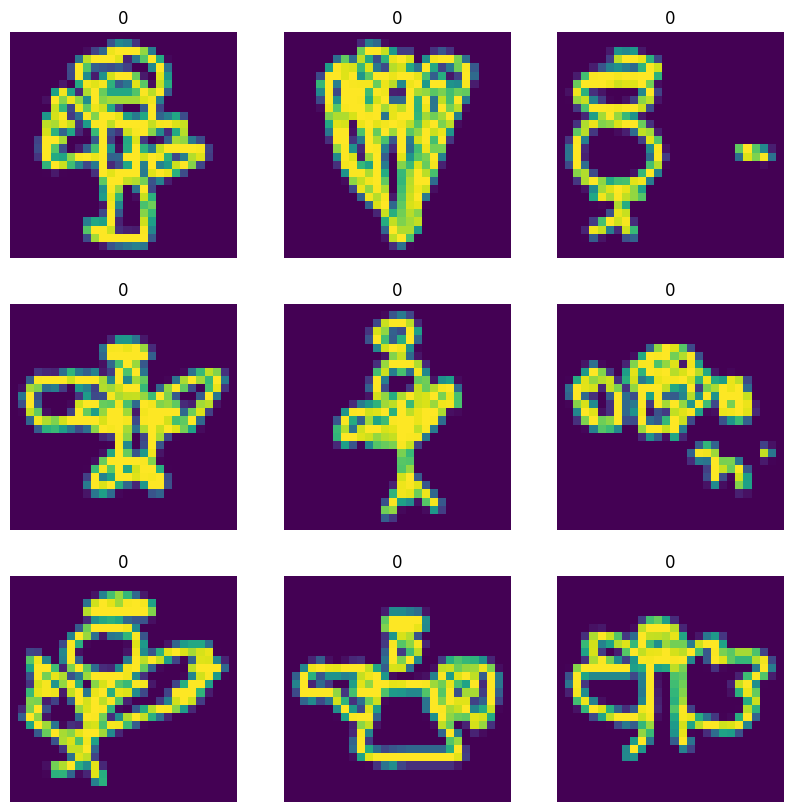

In [24]:
plt.figure(figsize=(10, 10))
for images, labels in dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        plt.title(int(labels[i]))
        plt.axis("off")

In [19]:
train_records

['gs://tfrecords-files/angel_train.tfrecords',
 'gs://tfrecords-files/ant_train.tfrecords',
 'gs://tfrecords-files/axe_train.tfrecords',
 'gs://tfrecords-files/basketball_train.tfrecords',
 'gs://tfrecords-files/bathtub_train.tfrecords',
 'gs://tfrecords-files/bear_train.tfrecords',
 'gs://tfrecords-files/bed_train.tfrecords',
 'gs://tfrecords-files/brain_train.tfrecords',
 'gs://tfrecords-files/bridge_train.tfrecords',
 'gs://tfrecords-files/cactus_train.tfrecords',
 'gs://tfrecords-files/calculator_train.tfrecords',
 'gs://tfrecords-files/camel_train.tfrecords',
 'gs://tfrecords-files/camera_train.tfrecords',
 'gs://tfrecords-files/car_train.tfrecords',
 'gs://tfrecords-files/carrot_train.tfrecords',
 'gs://tfrecords-files/castle_train.tfrecords',
 'gs://tfrecords-files/cat_train.tfrecords',
 'gs://tfrecords-files/church_train.tfrecords',
 'gs://tfrecords-files/circle_train.tfrecords',
 'gs://tfrecords-files/cloud_train.tfrecords',
 'gs://tfrecords-files/coffee cup_train.tfrecords',


In [32]:
client = storage.Client(project='plasma-kit-365110')
bucket = client.bucket(bucket_name='deepdraw')
for i in bucket.list_blobs():
    print(i.name)

apple_test.tfrecords
apple_train.tfrecords
apple_val.tfrecords


In [22]:
def parse_tfr_element(element):
    #use the same structure as above; it's kinda an outline of the structure we now want to create
    data = {
      'height': tf.io.FixedLenFeature([], tf.int64),
      'width':tf.io.FixedLenFeature([], tf.int64),
      'label':tf.io.FixedLenFeature([], tf.int64),
      'raw_image' : tf.io.FixedLenFeature([], tf.string),
      'depth':tf.io.FixedLenFeature([], tf.int64),
    }


    content = tf.io.parse_single_example(element, data)

    height = content['height']
    width = content['width']
    depth = content['depth']
    label = content['label']
    raw_image = content['raw_image']


    #get our 'feature'-- our image -- and reshape it appropriately
    feature = tf.io.parse_tensor(raw_image, out_type=tf.int64)
    feature = tf.reshape(feature, shape=[height,width,depth])
    return (feature, label)

In [8]:
def get_dataset_multi(tfr_dir: str = "/content/", pattern: str = "*.tfrecords"):
    files = glob.glob(os.path.join(tfr_dir, pattern), recursive=False)
    print(files)

    #create the dataset
    dataset = tf.data.TFRecordDataset(files)

    #pass every single feature through our mapping function
    dataset = dataset.map(parse_tfr_element)

    return dataset

In [11]:
dataset = get_dataset_multi(tfr_dir='./tfrecords', pattern="*train.tfrecords")
dataset = dataset.shuffle(buffer_size=112000)
dataset = dataset.batch(32)
dataset = dataset.map(lambda x, y:(tf.cast(x, tf.float32)/255.0, y))
for sample in dataset.take(2):
    print(sample[0].shape)
    print(sample[1].shape)

['./tfrecords/angel_train.tfrecords', './tfrecords/basketball_train.tfrecords']
(32, 28, 28, 1)
(32,)
(32, 28, 28, 1)
(32,)


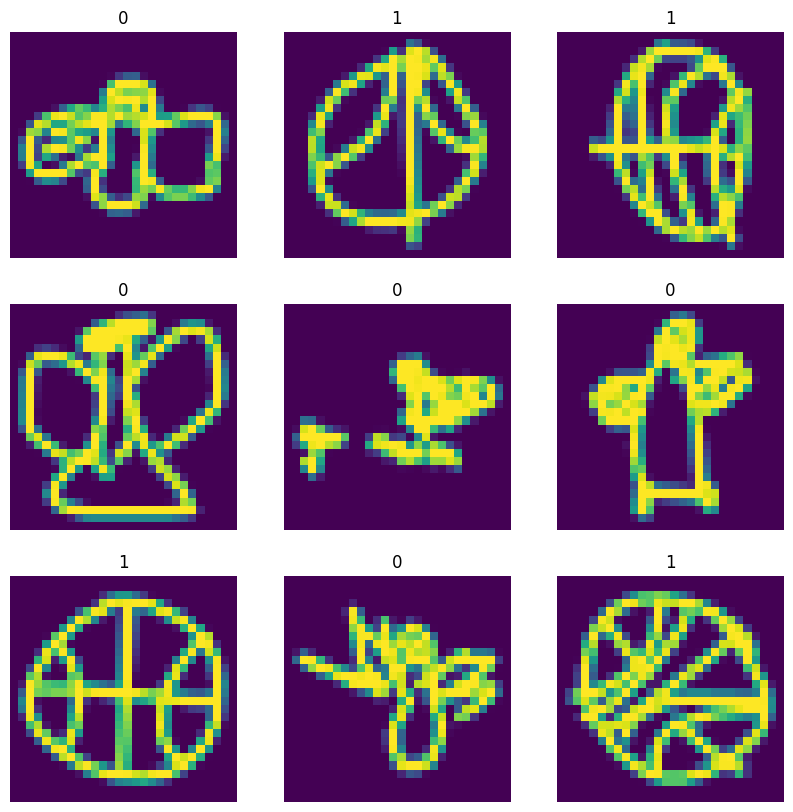

In [12]:
plt.figure(figsize=(10, 10))
for images, labels in dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        plt.title(int(labels[i]))
        plt.axis("off")

## TFrecords for RNN

In [4]:
import numpy as np
from sklearn.model_selection import train_test_split
from io import BytesIO
import tensorflow as tf
import numpy as np
from tensorflow.python.lib.io import file_io
import glob
import os

In [5]:
files = glob.glob(os.path.join('./ndjson', '*.ndjson'), recursive=False)
max_point = 0
class_names = []
for file in sorted(files) : 
    with open(file, 'r') as f :
        simp_ndjson_lines = f.readlines()
        class_name = json.loads(simp_ndjson_lines[0])['word']
        class_names.append(class_name)
        for i in range(len(simp_ndjson_lines)) :
            strokes = json.loads(simp_ndjson_lines[i])['drawing']
            stroke_lengths = [len(stroke[0]) for stroke in strokes]
            total_points = sum(stroke_lengths)
            max_point = max(max_point, total_points)

In [28]:
with open('./ndjson/full_simplified_angel.ndjson', 'r') as f :
    angels_simp_ndjson_lines = f.readlines()

In [7]:
max_point

1920

In [31]:
class_names

['The Eiffel Tower',
 'The Mona Lisa',
 'airplane',
 'angel',
 'banana',
 'baseball',
 'belt',
 'bench',
 'bird',
 'bridge',
 'bus',
 'cactus',
 'camel',
 'camera',
 'car',
 'carrot',
 'cat',
 'couch',
 'donut',
 'door',
 'dragon',
 'elephant',
 'envelope',
 'eye',
 'flower',
 'frog',
 'grapes',
 'hat',
 'hedgehog',
 'hexagon',
 'ice cream',
 'key',
 'light bulb',
 'moon',
 'mug',
 'pig',
 'pineapple',
 'pizza',
 'potato',
 'smiley face',
 'snake',
 'snowman',
 'spider',
 'star',
 'stop sign',
 'telephone',
 'television',
 'umbrella',
 'wheel',
 'windmill']

In [32]:
import yaml
with open(r'./categories_rnn_50.yaml', 'w') as file:
    documents = yaml.dump(sorted(class_names), file)

In [33]:
def to_big_strokes(stroke, max_len=500):
    """Converts from stroke-3 to stroke-5 format and pads to given length."""
    # (But does not insert special start token).

    result = np.zeros((max_len, 5), dtype=float)
    l = len(stroke)
    assert l <= max_len
    result[0:l, 0:2] = stroke[:, 0:2]
    result[0:l, 3] = stroke[:, 2]
    result[0:l, 2] = 1 - result[0:l, 3]
    result[l:, 4] = 1
    return result

In [34]:
def padding(stroke, max_len=500):
    """Converts from stroke-3 to stroke-5 format and pads to given length."""
    # (But does not insert special start token).

    result = np.ones((max_len, 3), dtype=float)*1000
    length = len(stroke)
    assert length <= max_len
    result[0:length, 0:3] = stroke[:, 0:3]
    return result

In [35]:
def parse_line(ndjson_line):
    """Parse an ndjson line and return ink (as np array) and classname."""
    sample = json.loads(ndjson_line)
    class_name = sample["word"]
    if not class_name:
        print ("Empty classname")
        return None, None
    inkarray = sample["drawing"]
    stroke_lengths = [len(stroke[0]) for stroke in inkarray]
    total_points = sum(stroke_lengths)
    np_ink = np.zeros((total_points, 3), dtype=np.float32)
    current_t = 0
    if not inkarray:
        print("Empty inkarray")
        return None, None
    for stroke in inkarray:
        if len(stroke[0]) != len(stroke[1]):
            print("Inconsistent number of x and y coordinates.")
            return None, None
        for i in [0, 1]:
            np_ink[current_t:(current_t + len(stroke[0])), i] = stroke[i]
        current_t += len(stroke[0])
        np_ink[current_t - 1, 2] = 1  # stroke_end
    # Preprocessing.
    # 1. Size normalization.
    lower = np.min(np_ink[:, 0:2], axis=0)
    upper = np.max(np_ink[:, 0:2], axis=0)
    scale = upper - lower
    scale[scale == 0] = 1
    np_ink[:, 0:2] = (np_ink[:, 0:2] - lower) / scale
    # 2. Compute deltas.
    np_ink[1:, 0:2] -= np_ink[0:-1, 0:2]
    np_ink = np_ink[1:, :]
    return padding(np_ink, max_len=max_point), class_name

In [36]:
len(parse_line(angels_simp_ndjson_lines[0])[0])

1920

In [67]:
angels_simp_ndjson_lines[0]

'{"word":"angel","countrycode":"US","timestamp":"2017-03-13 15:30:54.82243 UTC","recognized":false,"key_id":"5864802511486976","drawing":[[[93,103,104,139,140,149,84],[174,111,51,54,97,171,173]],[[103,81,58,50,42,20,7,0,1,10,23,121,124],[73,61,32,27,28,42,60,77,112,127,134,163,162]],[[140,148,158,187,214,250,255,254,250,237,220,209,179,147,145],[66,47,34,23,19,28,57,86,103,125,147,154,161,163,154]],[[113,108,101,101,113,130,140,142,131,116,115],[50,44,21,2,0,3,16,29,44,46,39]],[[110,112],[9,14]],[[123,123],[9,13]],[[120,120],[20,26]],[[113,116,123,133],[32,39,41,34]],[[96,93,87,85,90,94],[171,193,195,199,201,193]],[[138,143,150,150,147,141],[172,195,192,195,199,192]]]}\n'

In [37]:
parse_line(angels_simp_ndjson_lines[0])[0]

array([[ 3.92156839e-02, -3.13432813e-01,  0.00000000e+00],
       [ 3.92156839e-03, -2.98507482e-01,  0.00000000e+00],
       [ 1.37254924e-01,  1.49253905e-02,  0.00000000e+00],
       ...,
       [ 1.00000000e+03,  1.00000000e+03,  1.00000000e+03],
       [ 1.00000000e+03,  1.00000000e+03,  1.00000000e+03],
       [ 1.00000000e+03,  1.00000000e+03,  1.00000000e+03]])

In [38]:
import tensorflow as tf
import random

In [39]:
def convert_data(trainingdata_dir,
                 observations_per_class,
                 output_file,
                 classnames,
                 output_shards=10,
                 offset=0):
    """Convert training data from ndjson files into tf.Example in tf.Record.

    Args:
    trainingdata_dir: path to the directory containin the training data.
     The training data is stored in that directory as ndjson files.
    observations_per_class: the number of items to load per class.
    output_file: path where to write the output.
    classnames: array with classnames - is auto created if not passed in.
    output_shards: the number of shards to write the output in.
    offset: the number of items to skip at the beginning of each file.

    Returns:
    classnames: the class names as strings. classnames[classes[i]] is the
      textual representation of the class of the i-th data point.
    """

    def _pick_output_shard():
        return random.randint(0, output_shards - 1)

    file_handles = []
    # Open all input files.
    for filename in sorted(tf.compat.v1.gfile.ListDirectory(trainingdata_dir)):
        if not filename.endswith(".ndjson"):
            print("Skipping", filename)
            continue
        file_handles.append(
            tf.io.gfile.GFile(os.path.join(trainingdata_dir, filename), "r"))
        if offset != 0:  # Fast forward all files to skip the offset.
            count = 0
            for _ in file_handles[-1]:
                count += 1
                if count == offset:
                    break

    writers = []
    for i in range(output_shards):
        writers.append(
            tf.io.TFRecordWriter("%s-%05i-of-%05i" % (output_file, i,
                                                         output_shards)))

    reading_order = list(range(len(file_handles))) * observations_per_class
    random.shuffle(reading_order)

    for c in reading_order:
        line = file_handles[c].readline()
        ink = None
        while ink is None:
            ink, class_name = parse_line(line)
            if ink is None:
                print ("Couldn't parse ink from '" + line + "'.")
        if class_name not in classnames:
            classnames.append(class_name)
        features = {}
        features["class_index"] = _int64_feature(classnames.index(class_name))
        features["ink"] = _bytes_feature(serialize_array(ink))
        features["height"] = _int64_feature(ink.shape[0])
        features["width"] = _int64_feature(ink.shape[1])
        f = tf.train.Features(feature=features)
        example = tf.train.Example(features=f)
        writers[_pick_output_shard()].write(example.SerializeToString())

    # Close all files
    for w in writers:
        w.close()
    for f in file_handles:
        f.close()
    # Write the class list.
    with tf.io.gfile.GFile(output_file + ".classes", "w") as f:
        for class_name in classnames:
            f.write(class_name + "\n")
    return classnames

In [25]:
classnames = convert_data('./ndjson', 80000, "./tfrecords/train.tfrecords", class_names, output_shards=10, offset=0)
convert_data('./ndjson', 20000, "./tfrecords/test.tfrecords", class_names, output_shards=10, offset=80000)

Skipping .DS_Store


NameError: name '_int64_feature' is not defined

In [46]:
def parse_tfexample_fn2(element):
    """Parse a single record which is expected to be a tensorflow.Example."""
    feature_to_type = {
        "ink": tf.io.FixedLenFeature([], dtype=tf.string),
        "height": tf.io.FixedLenFeature([], dtype=tf.int64),
        "width": tf.io.FixedLenFeature([], dtype=tf.int64),
        "class_index" : tf.io.FixedLenFeature([], dtype=tf.int64)
    }
    
    content = tf.io.parse_single_example(element, feature_to_type)
    height = content["height"]
    width = content["width"]
    label= content["class_index"]
    raw_image = content["ink"]
    feature = tf.io.parse_tensor(raw_image, out_type=tf.double)
    feature = tf.reshape(feature, shape=[height,width])
    return (feature, label)

In [45]:
def get_dataset_rnn(tfr_dir: str = "/content/", pattern: str = "*.tfrecords"):
    files = glob.glob(os.path.join(tfr_dir, pattern), recursive=False)

    #create the dataset
    dataset = tf.data.TFRecordDataset(files)

    #pass every single feature through our mapping function
    dataset = dataset.map(parse_tfexample_fn2)

    return dataset

In [47]:
dataset = get_dataset_rnn('../../../deepdraw/raw_data/tfrecords', pattern="*train.tfrecords")
dataset = dataset.batch(32)
for sample in dataset.take(2):
    print(sample[0].shape)
    print(sample[1].shape)

(32, 1920, 3)
(32,)
(32, 1920, 3)
(32,)


2022-12-05 12:20:15.605462: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [33]:
def to_normal_strokes(big_stroke):
    """Convert from stroke-5 format (from sketch-rnn paper) back to stroke-3."""
    l = 0
    for i in range(len(big_stroke)):
        if big_stroke[i, 4] > 0:
            l = i
            break
    if l == 0:
        l = len(big_stroke)
    result = np.zeros((l, 3))
    result[:, 0:2] = big_stroke[0:l, 0:2]
    result[:, 2] = big_stroke[0:l, 3]
    return result

In [42]:
import os
import svgwrite
from IPython.display import SVG, display

def draw_strokes(data, factor=0.045, save=False, svg_filename = './svg/sample.svg', bounds=None):
    if save :
        if not os.path.exists(os.path.dirname(svg_filename)):
            os.makedirs(os.path.dirname(svg_filename))
    if bounds != None :
        min_x, max_x, min_y, max_y = bounds[0], bounds[1], bounds[2], bounds[3]
    else :    
        min_x, max_x, min_y, max_y = get_bounds(data, factor)
    dims = (50 + max_x - min_x, 50 + max_y - min_y)
    dwg = svgwrite.Drawing(svg_filename, size=dims)
    dwg.add(dwg.rect(insert=(0, 0), size=dims,fill='white'))
    lift_pen = 1
    abs_x = 25 - min_x 
    abs_y = 25 - min_y
    p = "M%s,%s " % (abs_x, abs_y)
    command = "m"
    for i in range(len(data)):
        if (lift_pen == 1):
            command = "m"
        elif (command != "l"):
            command = "l"
        else:
            command = ""
        x = float(data[i,0])/factor
        y = float(data[i,1])/factor
        lift_pen = data[i, 2]
        p += command+str(x)+","+str(y)+" "
    the_color = "black"
    stroke_width = 1
    dwg.add(dwg.path(p).stroke(the_color,stroke_width).fill("none"))
    if save:
        dwg.save()
    #display(SVG(dwg.tostring()))
    return dwg

def get_bounds(data, factor=1):
    """Return bounds of data."""
    min_x = 0
    max_x = 0
    min_y = 0
    max_y = 0

    abs_x = 0
    abs_y = 0
    for i in range(len(data)):
        x = float(data[i, 0]) / factor
        y = float(data[i, 1]) / factor
        abs_x += x
        abs_y += y
        min_x = min(min_x, abs_x)
        min_y = min(min_y, abs_y)
        max_x = max(max_x, abs_x)
        max_y = max(max_y, abs_y)
    return (min_x, max_x, min_y, max_y)